In [ ]:
import pandas as pd
from os import listdir
from datetime import datetime
import numpy as np



def read_comsumption_file(group_id):
    file_list = listdir("consumption_power")
    group_no_id_list = [f[:5] for f in file_list]
    consumption_power_name = file_list[group_no_id_list.index(group_id)] 
    return pd.read_csv("consumption_power/"+consumption_power_name)

def read_meteo_data_file(group_id):
    file_list = listdir("meteo_data")
    group_no_id_list = [f[-9:-4] for f in file_list]
    meteo_data_name = file_list[group_no_id_list.index(group_id)] 
    return pd.read_csv("meteo_data/"+meteo_data_name)


def read_date(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

def set_dates(df):
    df["datetime"] = [read_date(date) for date in df.timestamp]
    df["date"] = [d.date() for d in df["datetime"]]

def change_scale(df):
    """return the aggregation by day"""
    df_by_date = df.groupby("date").agg("sum").reset_index()
    return df_by_date

#read data
n0 = 4
group_id_no = str(82024)
consumption_df = pd.read_csv("consumption_data.csv")
meteo_df = pd.read_csv("meteo_data.csv")

#set dates
set_dates(meteo_df)
set_dates(consumption_df)

meteo_df.index = meteo_df['datetime']
consumption_df.index = consumption_df['datetime']
consumption_df_resampled = consumption_df.resample("1h").sum()[1:]
merged_df = pd.merge(meteo_df,consumption_df_resampled, how='inner', left_index=True, right_index=True,sort =True)
merged_df.head()

#features 

#features list :
#   time features : hour, weekday, month, season ?
#   consumption features : mean past week, delta mean past weeks, delta² ?
#   meteo features : tmp2m, wnd10m_u, wnd10m_v, tcdcclm, prate



df_X = merged_df["datetime"]
#time 
merged_df["date"] = merged_df["date"]
merged_df["hour"] = [d.hour for d in merged_df["datetime"]]
merged_df["weekday"] = [d.weekday() for d in merged_df["datetime"]]
merged_df["month"] = [d.month for d in merged_df["datetime"]]
merged_df["year"] = [d.year for d in merged_df["datetime"]]
#meteo
merged_df["wnd"] = np.sqrt(merged_df["wnd10m_u"]**2+merged_df["wnd10m_v"]**2)
#consumption
n_day_mean = 7
n_day_pred = 5
#mean mw of the week 5 days before
merged_df["mean_mw_past_week"] = merged_df["underlying_mw"].rolling(24*n_day_mean).mean().shift(-24*n_day_pred) 
merged_df = merged_df[(n_day_pred+n_day_mean)*24:]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import tensorflow as tf

n_pred = 24*5

In [ ]:

def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    index_y = list(tt.columns).index("underlying_mw") #todo 
    index_y = 0

    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, index_y:], sequences[end_ix-1:out_end_ix, index_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)



time_features=["hour", "weekday", "month","year"]
consumption_features=["mean_mw_past_week"]
meteo_features=["tmp2m", "wnd", "tcdcclm", "prate"]
features = time_features+consumption_features+meteo_features

X = merged_df[features]
Y = merged_df["underlying_mw"]

#split train test
i_split = int(len(X)*0.8)

dataset_lstm = merged_df[["underlying_mw","hour", "weekday", "month","year","tmp2m","prate"]]

train = dataset_lstm[:i_split]
test = dataset_lstm[i_split:]

tt = train.reset_index().drop("datetime",axis = 1)



# to_drop = ["datetime","timestamp","date"]
# tt = train.drop("datetime",axis = 1).reset_index().drop(to_drop,axis=1)



scaler = MinMaxScaler()
scaled_tt = scaler.fit_transform(tt)
# scaled_tt = pd.DataFrame(scaler.fit_transform(tt),columns = tt.columns)

scaled_tt = scaled_tt[10000:]
ttrain=scaled_tt[:2000]
ttest=scaled_tt[2000:3000]
print(ttrain.shape)

look_back = 24*7
look_forward =24*5
    
trainX,trainY = split_sequences(ttrain,look_back,look_forward)
testX,testY = split_sequences(ttest,look_back,look_forward)

dropout = 0.2
# the dataset knows the number of features, e.g. 2
n_features = trainX.shape[2]
print("n_features = ",n_features)
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(look_back,n_features)))
model.add(Dropout(dropout))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(50, activation='relu'))
model.add(Dense(look_forward))
model.compile(optimizer='adam', loss='mse')

# fit model
es =tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode ='min',verbose = 1, patience = 5)

model.fit(trainX,trainY, epochs=10,validation_split=0.15,callbacks = [es])
# demonstrate prediction

preds = model.predict(testX, verbose=0)


(2000, 7)
n_features =  7
Epoch 1/10
46/46 [==============================] - 14s 226ms/step - loss: 1705379984042.0132 - val_loss: 0.1943
Epoch 2/10
46/46 [==============================] - 10s 216ms/step - loss: 0.1732 - val_loss: 0.1913
Epoch 3/10
46/46 [==============================] - 10s 214ms/step - loss: 0.1702 - val_loss: 0.1862
Epoch 4/10
46/46 [==============================] - 10s 214ms/step - loss: 0.1652 - val_loss: 0.1809
Epoch 5/10
46/46 [==============================] - 10s 217ms/step - loss: 0.1600 - val_loss: 0.1755
Epoch 6/10
46/46 [==============================] - 10s 214ms/step - loss: 0.1551 - val_loss: 0.1701
Epoch 7/10
46/46 [==============================] - 10s 214ms/step - loss: 0.1501 - val_loss: 0.1647
Epoch 8/10
46/46 [==============================] - 10s 216ms/step - loss: 0.1449 - val_loss: 0.1593
Epoch 9/10
46/46 [==============================] - 10s 216ms/step - loss: 0.1410 - val_loss: 0.1540
Epoch 10/10
46/46 [==============================] - 

In [ ]:
len(ttrain)

2000

In [ ]:
model.fit(trainX,trainY, epochs=10,validation_split=0.15,callbacks = [es])

preds = model.predict(testX, verbose=0)


Epoch 1/10
46/46 [==============================] - 7s 143ms/step - loss: 8.9524e-04 - val_loss: 0.0017
Epoch 2/10
46/46 [==============================] - 6s 137ms/step - loss: 8.9888e-04 - val_loss: 0.0016
Epoch 3/10
46/46 [==============================] - 6s 137ms/step - loss: 9.1334e-04 - val_loss: 0.0015
Epoch 4/10
46/46 [==============================] - 6s 138ms/step - loss: 8.8749e-04 - val_loss: 0.0014
Epoch 5/10
46/46 [==============================] - 6s 137ms/step - loss: 8.8947e-04 - val_loss: 0.0013
Epoch 6/10
46/46 [==============================] - 6s 140ms/step - loss: 8.5538e-04 - val_loss: 0.0015
Epoch 7/10
46/46 [==============================] - 6s 140ms/step - loss: 8.5719e-04 - val_loss: 0.0016
Epoch 8/10
46/46 [==============================] - 6s 140ms/step - loss: 8.8749e-04 - val_loss: 0.0014
Epoch 9/10
46/46 [==============================] - 6s 141ms/step - loss: 8.4976e-04 - val_loss: 0.0014
Epoch 10/10
46/46 [==============================] - 6s 141ms/st

<Figure size 432x288 with 0 Axes>

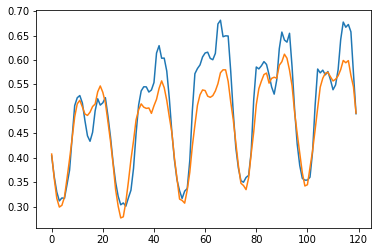

<Figure size 432x288 with 0 Axes>

In [ ]:
preds = model.predict(testX, verbose=0)
plt.plot(testY[0])

plt.plot(preds[0])
# plt.figure()
plt.figure()

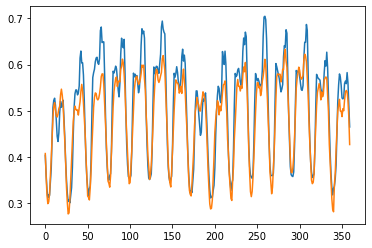

In [ ]:
# plt.plot(preds[24*0])
# plt.plot(preds[24*5])
# plt.plot(preds[24*10])
# plt.figure(figsize=(15,10))
plt.plot(np.concatenate((testY[24*0],testY[24*5],testY[24*10])))
plt.plot(np.concatenate((preds[24*0],preds[24*5],preds[24*10])))


In [ ]:
def get_average_error(y_test,pred, n_pred = n_pred):
    rmse = mean_squared_error(y_test[:n_pred],pred[:n_pred],squared=False)
    error = rmse/(y_test.mean())
    return error
  
print("avg errror" , get_average_error(testY[0],preds[0]))


avg errror 0.0910316469128206


In [ ]:
testY[0].shape

(120,)

In [ ]:
preds[0].shape

(120,)

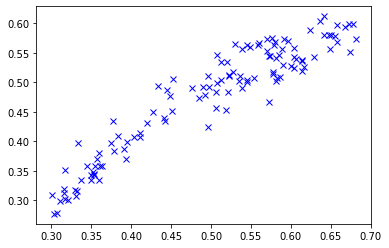

In [ ]:
plt.plot(testY[0],preds[0],"bx")